<a href="https://colab.research.google.com/github/K4RMA22/Movie-Recomender/blob/main/Projecto_Filmes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [271]:
# Imports necessários
import pandas as pd
import requests
import os
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from surprise import accuracy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import TruncatedSVD
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split, GridSearchCV
from surprise.accuracy import rmse
from difflib import get_close_matches
from IPython.display import display, HTML,clear_output

# Definir estilos CSS globais para inputs e tabelas
display(HTML('''
<style>
  textarea {
        width: 10px !important;
        height: 20px !important;
  }
    table.dataframe {
        width: 100% !important;
        border-collapse: collapse !important;
    }
    table.dataframe th, table.dataframe td {
        padding: 8px !important;
        text-align: left !important;
        border: 1px solid #ddd !important;
    }
    table.dataframe th {
        background-color: #f4f4f4 !important;
    }
</style>
'''))




# Explicação:
Faz o download de um arquivo e o salva no diretório temporário, caso ainda não exista.

**Parâmetros:**        
1.   url (str): URL do arquivo para download.
2.   filename (str): Nome do arquivo a ser salvo localmente.      


    

In [276]:

def download_file(url, filename):
    # Caminho para salvar o arquivo
    file_path = os.path.join(temp_dir, filename)

    # Verificar se o arquivo já foi baixado
    if not os.path.exists(file_path):
        print(f"Download {filename}...")
        response = requests.get(url, stream=True)
        # Salvar o arquivo em modo binário
        with open(file_path, "wb") as f:
            f.write(response.content)
    else:
        print(f"{filename} feito.")

    # Retornar o caminho completo do arquivo
    return file_path

def load_filtered_tsv(file_path, columns=None, filters=None, chunksize=500000):

    print(f"Carregando {file_path}...")
    chunks = []

    # Abrir o ficheiro compactado em modo de leitura de texto
    with gzip.open(file_path, 'rt', encoding='utf-8') as f:
        for chunk in pd.read_csv(f, sep='\t', usecols=columns, chunksize=chunksize, low_memory=False):
            if filters:
                for col, values in filters.items():
                    chunk = chunk[chunk[col].isin(values)]
            chunks.append(chunk)

    # Combinar todos os chunks em um único DataFrame
    return pd.concat(chunks, ignore_index=True)

# URLs das datasets IMDb
datasets = {
    "title.basics.tsv": "https://datasets.imdbws.com/title.basics.tsv.gz",
    "title.ratings.tsv": "https://datasets.imdbws.com/title.ratings.tsv.gz",
    "title.principals.tsv": "https://datasets.imdbws.com/title.principals.tsv.gz",
    "title.crew.tsv": "https://datasets.imdbws.com/title.crew.tsv.gz",
}

files = {name: download_file(url, name) for name, url in datasets.items()}

# Carregar e filtrar os ficheiros necessários.
title_basics = load_filtered_tsv(
    files["title.basics.tsv"],
    columns=["tconst", "primaryTitle", "titleType", "genres", "startYear"],
    filters={"titleType": ["movie"]}
)

title_ratings = load_filtered_tsv(
    files["title.ratings.tsv"],
    columns=["tconst", "averageRating", "numVotes"]
)

title_principals = load_filtered_tsv(
    files["title.principals.tsv"],
    columns=["tconst", "nconst", "category"],
    filters={"category": ["actor", "actress", "director", "writer"]}
    )

title_crew = load_filtered_tsv(
    files["title.crew.tsv"],
    columns=["tconst", "directors", "writers"]
    )


title.basics.tsv já baixado.
title.ratings.tsv já baixado.
title.principals.tsv já baixado.
title.crew.tsv já baixado.
Carregando ./temp_imdb_datasets/title.basics.tsv com filtragem...
Carregando ./temp_imdb_datasets/title.ratings.tsv com filtragem...
Carregando ./temp_imdb_datasets/title.principals.tsv com filtragem...
Carregando ./temp_imdb_datasets/title.crew.tsv com filtragem...


# Descrição da Função **preprocess_data**
  A função preprocess_data é responsável pelo processamento preliminar dos dados das tabelas fornecidas pelo IMDb, combinando informações relevantes e filtrando registos para gerar um conjunto de dados consolidado. O objetivo final é preparar os dados para modelos de análise ou recomendação de filmes.

**Parâmetros:**
*   **title_basics** (DataFrame): Contém informações básicas sobre os títulos, como o tipo (titleType), o título principal (primaryTitle), os géneros (genres) e o ano de lançamento (startYear).
---
*   **title_ratings** (DataFrame): Inclui as avaliações médias (averageRating) e o número de votos (numVotes) dos títulos.
---
*   **title_principals** (DataFrame): Contém informações sobre o elenco e a equipa técnica dos filmes, como identificações de pessoas (nconst) e funções desempenhadas (category).
---
*   **title_crew** (DataFrame): Contém IDs de diretores e escritores de guiões para os filmes.







In [300]:
def preprocess_data(title_basics, title_ratings, title_principals, title_crew):

    # Filtrar apenas filmes
    movies = title_basics[title_basics['titleType'] == 'movie'].copy()
    movies.rename(columns={'tconst': 'movie_id', 'primaryTitle': 'title', 'genres': 'genre', 'startYear': 'year'}, inplace=True)

    # Combinar com ratings
    ratings = title_ratings.rename(columns={'tconst': 'movie_id', 'averageRating': 'rating', 'numVotes': 'votes'})
    movies = movies.merge(ratings, on='movie_id', how='inner')

   # Filtrar filmes com classificação superior a 5.0 e com pelo menos 3.000 votos.
    movies = movies[(movies['rating'] > 5.0) & (movies['votes'] >= 3000)]

    # Adicionar informações sobre o elenco e a equipa
    principals = title_principals.rename(columns={'tconst': 'movie_id', 'category': 'role', 'nconst': 'person_id'})
    crew = title_crew.rename(columns={'tconst': 'movie_id'})
    crew['crew'] = crew[['directors', 'writers']].fillna('').apply(lambda x: ' '.join(x), axis=1)
    principals_grouped = principals.groupby('movie_id')['person_id'].apply(lambda x: ' '.join(x)).reset_index()

    # Combinar todas as informações
    movies = movies.merge(crew[['movie_id', 'crew']], on='movie_id', how='left')
    movies = movies.merge(principals_grouped, on='movie_id', how='left')

    # Criar coluna de "combined_features" para modelos de recomendação
    movies['combined_features'] = (
        movies['genre'].fillna('') + ' ' +
        movies['title'].fillna('') + ' ' +
        movies['crew'].fillna('') + ' ' +
        movies['person_id'].fillna('')
    )

    # Eliminar duplicados e registos em falta
    return movies.drop_duplicates(subset=['movie_id']).dropna()

    # Pré-processar os dados
movies = preprocess_data(title_basics, title_ratings, title_principals, title_crew)



# Explicação:

- Primeiro, dividimos a coluna de géneros para que cada género conte como uma entrada separada.
- Em seguida, usamos a função `value_counts()` para obter a contagem de cada género.
- O gráfico de barras foi estilizado com uma paleta de cores e bordas nas barras.

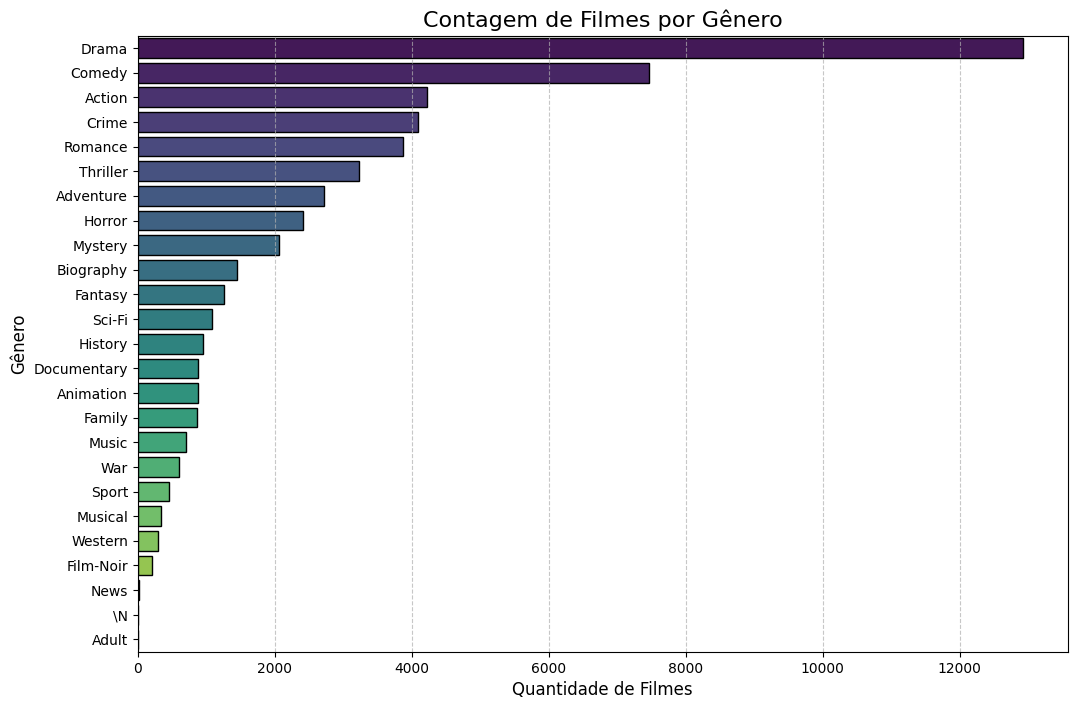

In [301]:
# Passo 1: Contagem de Filmes por Género
plt.figure(figsize=(12, 8))

# Obter a contagem de géneros
genre_counts = movies['genre'].str.split(",").explode().value_counts()

# Gráfico de contagem por género
sns.barplot(
    x=genre_counts.values,
    y=genre_counts.index,
    palette="viridis",
    edgecolor="black",
    hue=genre_counts.index,
    dodge=False
)

# Ajustar títulos e rótulos
plt.title("Contagem de Filmes por Gênero", fontsize=16)
plt.xlabel("Quantidade de Filmes", fontsize=12)
plt.ylabel("Gênero", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.legend([], [], frameon=False)
plt.show()


# Evolução Temporal de Filmes
**Descrição do Gráfico**

O gráfico mostra a quantidade de filmes lançados por ano ao longo do tempo.

Trata-se de uma linha temporal que ajuda a compreender a evolução da produção cinematográfica.

- O eixo X representa o ano de lançamento dos filmes.

- O eixo Y indica o número de filmes lançados nesse ano.

Cada ponto no gráfico corresponde ao número de filmes produzidos num ano específico.

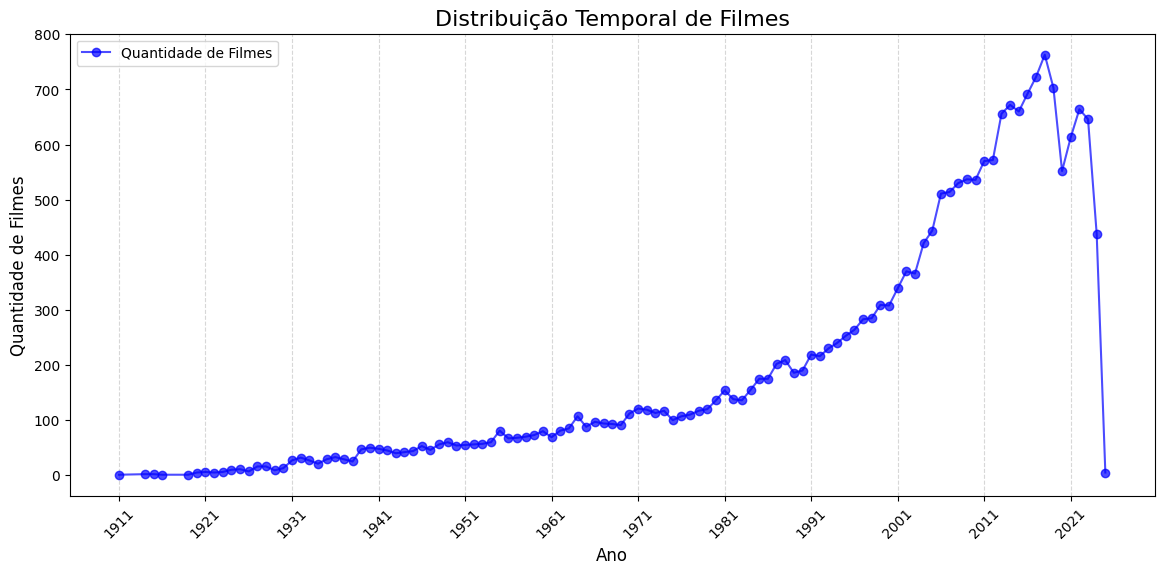

In [302]:
# Passo 2: Evolução Temporal de Filmes
plt.figure(figsize=(14, 6))

# Contagem de filmes por ano
year_counts = movies['year'].value_counts().sort_index()

# Convertendo o índice para numérico
year_counts.index = pd.to_numeric(year_counts.index, errors='coerce')

# Gráfico de linha
plt.plot(
    year_counts.index,
    year_counts.values,
    marker='o',
    linestyle='-',
    color='blue',
    alpha=0.7,
    label='Quantidade de Filmes'
)

# Adicionando rótulos no eixo X a cada 10 anos para evitar sobreposição
plt.xticks(
    ticks=range(int(year_counts.index.min()), int(year_counts.index.max()) + 1, 10),
    rotation=45,
    fontsize=10
)

# Ajustando o título e os rótulos dos eixos.
plt.title("Distribuição Temporal de Filmes", fontsize=16)
plt.xlabel("Ano", fontsize=12)
plt.ylabel("Quantidade de Filmes", fontsize=12)

plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.legend()
plt.show()

# Explicação:
- A escala logarítmica é utilizada para votos devido à grande variação dos valores.
- O gráfico de dispersão ajuda a identificar padrões, como filmes com muitos votos e classificação elevada.

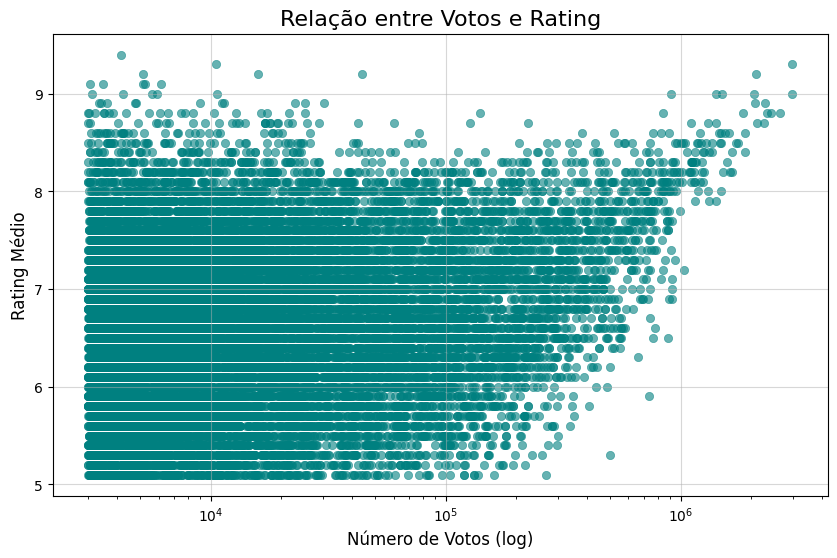

In [303]:
# 3. Relação entre Rating e Votos
plt.figure(figsize=(10, 6))

# Gráfico de dispersão
sns.scatterplot(
    data=movies,
    x='votes',
    y='rating',
    alpha=0.6,
    edgecolor=None,
    color='teal'
)

# Ajustar escalas e rótulos
plt.xscale("log")
plt.title("Relação entre Votos e Rating", fontsize=16)
plt.xlabel("Número de Votos (log)", fontsize=12)
plt.ylabel("Rating Médio", fontsize=12)
plt.grid(alpha=0.5)
plt.show()




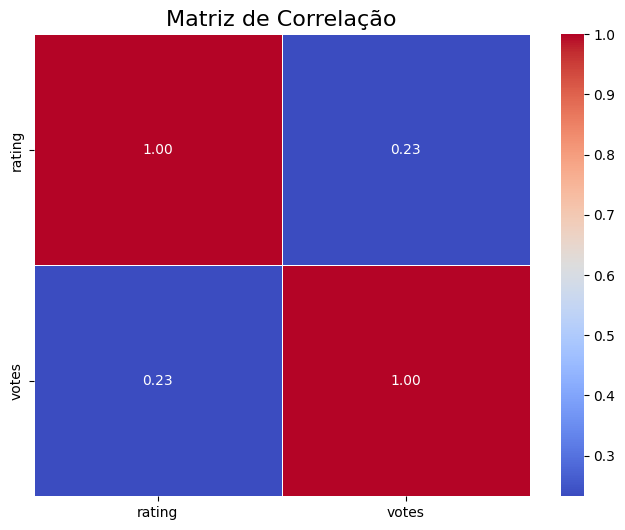

In [304]:
# 4. Matriz de correlação entre variáveis numéricas
corr_matrix = movies[['rating', 'votes']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação", fontsize=16)
plt.show()

# Interpretação dos Valores
**Correlação entre rating e rating:**

- O valor 1.00 indica uma correlação perfeita positiva (óbvia, pois é a mesma variável comparada a si mesma).

Correlação entre votos:
- O valor 1.00 também indica uma correlação positiva perfeita pela mesma razão acima referida.

**Correlação entre rating e votos:**

- O valor 0.23 mostra uma correlação fraca positiva:

 Filmes com mais votos tendem a ter classificações mais elevadas, mas essa relação não é forte.

- Isso sugere que o número de votos não é um determinante direto da classificação.

**Correlação entre votos e rating:**
- Igual ao anterior (0.23), já que a matriz é simétrica.

# Explicação:
- Removemos os valores inválidos (NULL) da coluna género.
- A coluna "género" foi separada em valores individuais usando o método `.explode()`.
- Calculamos a média de avaliação por género com `.groupby()` e `.mean()`.
- O gráfico exibe os géneros  ordenados pela média de avaliação.

<ipython-input-305-652470cee97a>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


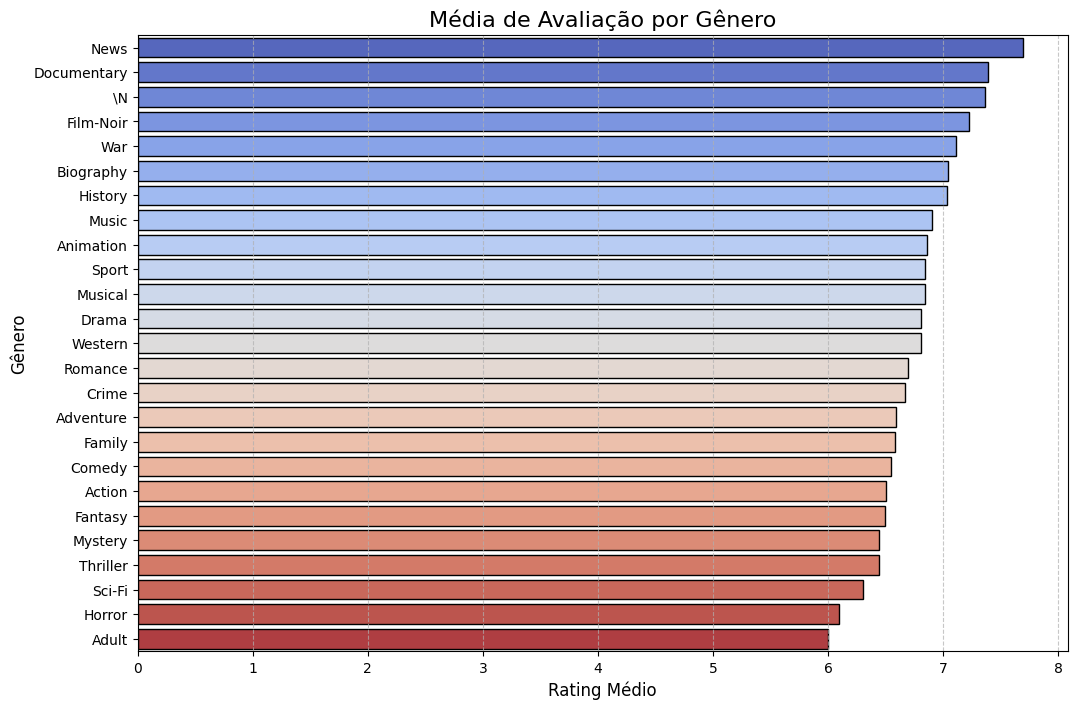

In [305]:


# Separar os géneros em linhas individuais.
movies_exploded = movies.copy()
movies_exploded['genre'] = movies_exploded['genre'].str.split(",")
movies_exploded = movies_exploded.explode('genre')

# Calcular a média de avaliação por género
genre_ratings = movies_exploded.groupby('genre')['rating'].mean().sort_values(ascending=False)

# Gráfico de barras para a média de avaliação por género
plt.figure(figsize=(12, 8))
sns.barplot(
    x=genre_ratings.values,
    y=genre_ratings.index,
    palette="coolwarm",
    edgecolor="black",
    legend=False
)

# Ajustar o gráfico
plt.title("Média de Avaliação por Gênero", fontsize=16)
plt.xlabel("Rating Médio", fontsize=12)
plt.ylabel("Gênero", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()




# Explicação:
- Os filmes com mais votos foram selecionados usando `nlargest`.
- O gráfico mostra quais filmes têm maior engajamento do público.

<ipython-input-306-c363c03671f4>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


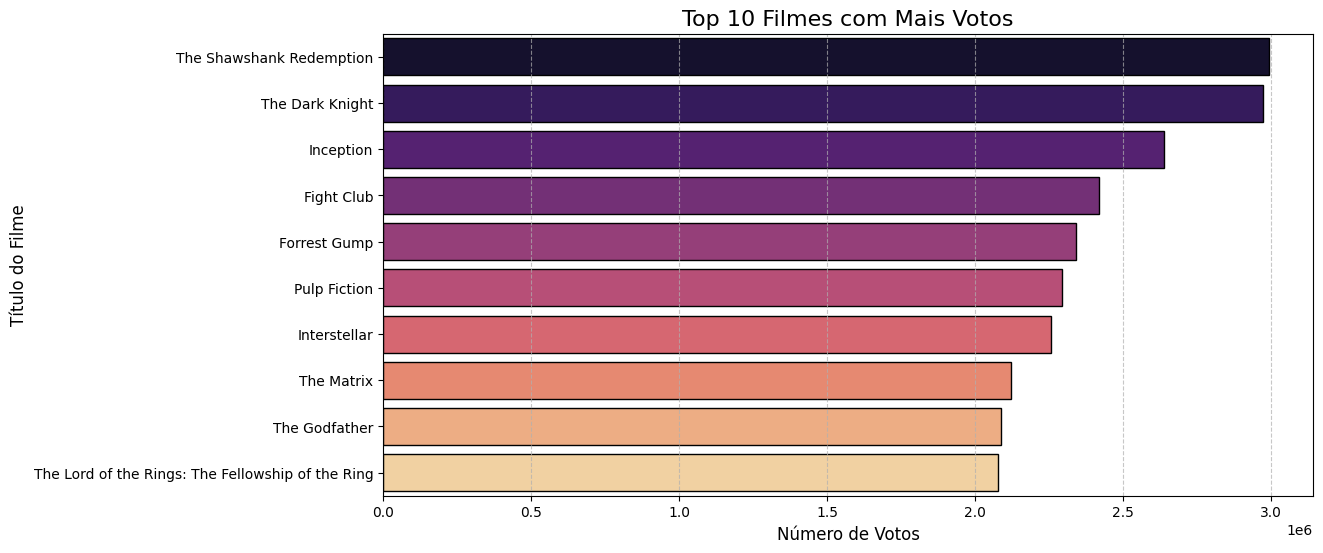

In [306]:
# Passo 6: Top 10 Filmes com Mais Votos
plt.figure(figsize=(12, 6))

# Obter os 10 filmes mais votados
top_voted_movies = movies.nlargest(10, 'votes')

# Gráfico de barras
sns.barplot(
    x=top_voted_movies['votes'],
    y=top_voted_movies['title'],
    palette="magma",
    edgecolor="black",
    legend=False
)

plt.title("Top 10 Filmes com Mais Votos", fontsize=16)
plt.xlabel("Número de Votos", fontsize=12)
plt.ylabel("Título do Filme", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()




# Treino de models
Adotámos o SVD e o NN para o treino, mas mais tarde percebemos que não fazia sentido continuar com o SVD devido à falta de feedback do utilizador em termos de classificação e votos.

Deixámos o SVD de parte para, de seguida, fazer uma breve comparação entre os dois.

Realizando a vetorização das características combinadas...
Reduzindo dimensionalidade com SVD...


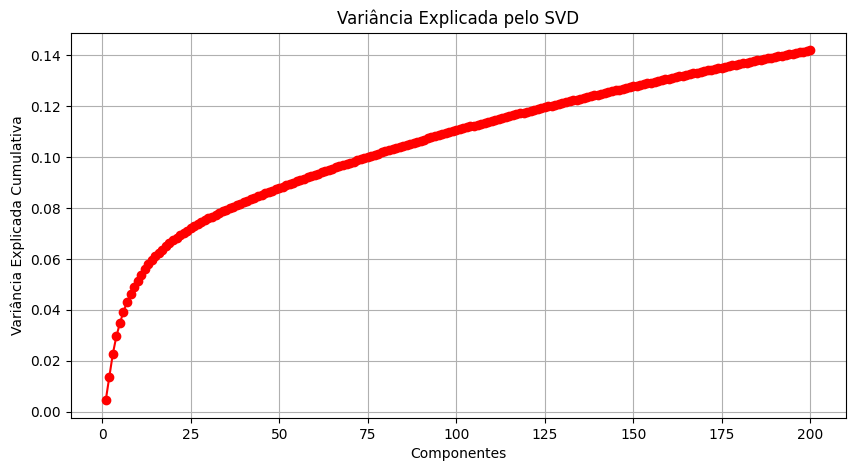

Treino do modelo NearestNeighbors...

 Treino de modelo SVD com otimização de hiperparâmetros...
Avaliando o modelo SVD...
RMSE: 0.0615


In [307]:
# Vetorização de géneros e títulos
print("Realizando a vetorização das características combinadas...")
vectorizer = CountVectorizer()
feature_matrix = vectorizer.fit_transform(movies['combined_features'])

# Reduzindo dimensionalidade com SVD
print("Reduzindo dimensionalidade com SVD...")
svd = TruncatedSVD(n_components=200, random_state=42)
reduced_matrix = svd.fit_transform(feature_matrix)

# Visualização da variância explicada pelo SVD
explained_variance = svd.explained_variance_ratio_.cumsum()
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(explained_variance) + 1), explained_variance, marker='o', color='red')
plt.title("Variância Explicada pelo SVD")
plt.xlabel("Componentes")
plt.ylabel("Variância Explicada Cumulativa")
plt.grid()
plt.show()

# Treino do modelo NearestNeighbors
print("Treino do modelo NearestNeighbors...")
nn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=50, n_jobs=-1)
nn_model.fit(reduced_matrix)

# Treino de modelo SVD com otimização de hiperparâmetros.
print("\n Treino de modelo SVD com otimização de hiperparâmetros...")
reader = Reader(rating_scale=(1, 10))
data = Dataset.load_from_df(movies[['movie_id', 'rating', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

param_grid = {'n_factors': [50, 100],
              'n_epochs': [20, 30],
              'lr_all': [0.002, 0.005],
              'reg_all': [0.02, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(Dataset.load_from_df(movies[['movie_id', 'rating', 'rating']].sample(5000), reader))

best_model = gs.best_estimator['rmse']
best_model.fit(trainset)

# Avaliação do modelo SVD no conjunto de teste
print("Avaliando o modelo SVD...")
test_predictions = best_model.test(testset)
rmse_score = rmse(test_predictions)




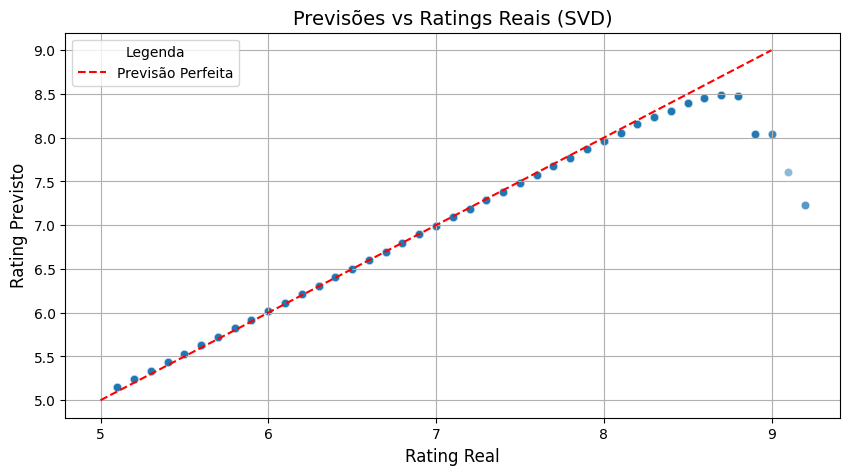

In [308]:
# Criando um DataFrame com as previsões do modelo
predictions_df = pd.DataFrame(
    [(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in test_predictions],
    columns=['User', 'Movie', 'Real Rating', 'Predicted Rating']
)

# Configurando a visualização do gráfico
plt.figure(figsize=(10, 5))

# Adicionando a linha de referência para previsões perfeitas (y = x)
plt.plot([5, 9], [5, 9], color='red', linestyle='--', label='Previsão Perfeita')

# Adicionando os pontos do scatterplot
sns.scatterplot(
    x='Real Rating',
    y='Predicted Rating',
    data=predictions_df,
    alpha=0.5
)

# Adicionando título, rótulos e grade
plt.title("Previsões vs Ratings Reais (SVD)", fontsize=14)
plt.xlabel("Rating Real", fontsize=12)
plt.ylabel("Rating Previsto", fontsize=12)
plt.grid()

plt.legend(title="Legenda", fontsize=10, loc='upper left')
plt.show()



# Parâmetros:

*   user_input (list): Lista de títulos de filmes fornecidos pelo usuário.
*   movies (DataFrame): Base de dados de filmes.
*   nn_model (NearestNeighbors): Modelo treinado para recomendações.
*   reduced_matrix (numpy.ndarray): Matriz reduzida de características.
*   n_recommendations (int): Número de recomendações para cada input.

    Retorna:
        DataFrame estilizado com as recomendações.

In [340]:
def movie_recommendation(user_input, movies, nn_model, reduced_matrix, n_recommendations=20):
    final_input = []
    genres_input = set()
    selected_titles = []

    for title in user_input:
        matches = movies[movies['title'].str.contains(title, case=False, na=False)]

        if len(matches) > 50:
            print(f"O título '{title}' é muito genérico. Refinando busca...")
            matches = matches[matches['title'].str.len() <= len(title) + 5]

        if len(matches) > 1:
            print(f"O título '{title}' é ambíguo. Selecione uma das opções abaixo (máximo 10 opções):")
            limited_matches = matches[['title', 'year', 'genre']].head(10).reset_index(drop=True)
            limited_matches.index += 1
            display(limited_matches.style.set_table_attributes("style='display:inline'"))
            selected_index = int(input("Digite o número da opção desejada (ou -1 para pular): "))
            clear_output(wait=True)

            if selected_index != -1:
                selected_row = matches.iloc[selected_index - 1]
                final_input.append(selected_row['combined_features'])
                genres_input.update(selected_row['genre'].split(","))
                selected_titles.append(selected_row['title'])
            else:
                selected_titles.append(title)
        elif len(matches) == 1:
            selected_row = matches.iloc[0]
            final_input.append(selected_row['combined_features'])
            genres_input.update(selected_row['genre'].split(","))
            selected_titles.append(selected_row['title'])
        else:
            print(f"Nenhuma correspondência encontrada para '{title}'.")
            selected_titles.append(title)

    if not final_input:
        return None, None, None

    valid_indices = [
        idx for idx, feature in enumerate(movies['combined_features'])
        if feature in final_input
    ]

    if len(valid_indices) == 0:
        return None, None, None

    distances, indices = nn_model.kneighbors(reduced_matrix[valid_indices], n_neighbors=n_recommendations + 1)
    recommended_indices = set(indices.flatten()) - set(valid_indices)
    recommended_movies = movies.iloc[list(recommended_indices)].copy()

    def genre_overlap(genres):
        genres_movie = set(genres.split(","))
        return len(genres_movie & genres_input)

    recommended_movies['genre_overlap'] = recommended_movies['genre'].apply(genre_overlap)
    recommended_movies = recommended_movies[recommended_movies['genre_overlap'] > 0]

    recommended_movies['priority_score'] = (
        recommended_movies['genre_overlap'] * 2 +
        recommended_movies['rating'] +
        np.log1p(recommended_movies['votes'])
    )

    recommended_movies = recommended_movies.sort_values(by='priority_score', ascending=False)

    print(f"\nRecomendações baseadas no título '{', '.join(selected_titles)}':")
    return recommended_movies.head(n_recommendations), distances, indices



Recomendações baseadas no título 'Avatar: The Way of Water, The Lord of the Rings: The Fellowship of the Ring, Harry Potter and the Sorcerer's Stone, Avengers: Age of Ultron, Star Wars: Episode IV - A New Hope':


<ipython-input-348-fbb3fc8b7092>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


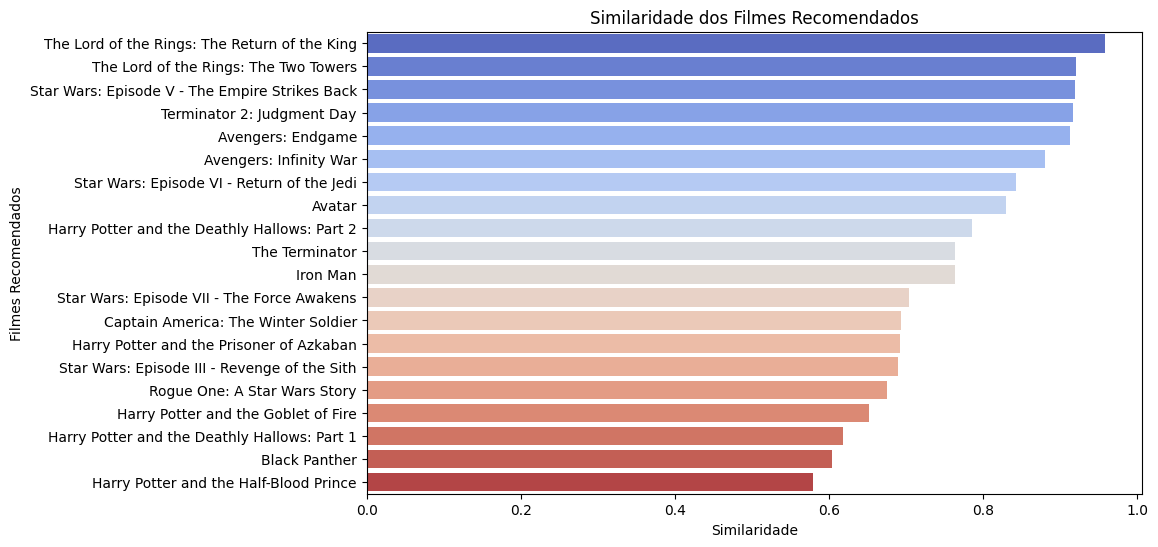

In [348]:
user_input = [
    'Avatar: The Way of Water',
    'The Lord of the Rings: The Fellowship of the Ring',
    'Harry Potter and the Sorcerer\'s Stone',
    'Avengers: Age of Ultron',
    'Star Wars: Episode IV - A New Hope'
]

# Chamando a função de recomendação com gráficos
recommended_movies, distances, indices = movie_recommendation(user_input, movies, nn_model, reduced_matrix)

# Garantir que o número de distâncias corresponde ao número de títulos recomendados
if recommended_movies is not None:
    distances_flat = distances.flatten()[1:len(recommended_movies) + 1]  # Ajustar o tamanho do array de distâncias

    plt.figure(figsize=(10, 6))
    sns.barplot(
        x=1 - distances_flat,  # Similaridade (1 - distância)
        y=recommended_movies['title'],
        palette="coolwarm"
    )
    plt.title("Similaridade dos Filmes Recomendados")
    plt.xlabel("Similaridade")
    plt.ylabel("Filmes Recomendados")
    plt.show()
else:
    print("Nenhuma recomendação foi gerada.")



Recomendações baseadas no título 'Avatar: The Way of Water, The Lord of the Rings: The Fellowship of the Ring, Harry Potter and the Sorcerer's Stone, Avengers: Age of Ultron, Star Wars: Episode IV - A New Hope':


<ipython-input-360-10967e0f22cf>:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


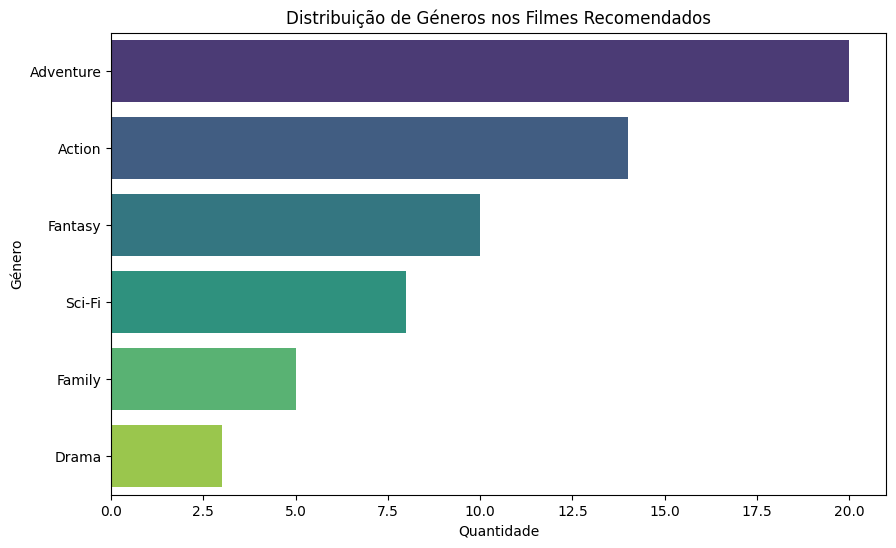

In [360]:
user_input = [
    'Avatar: The Way of Water',
    'The Lord of the Rings: The Fellowship of the Ring',
    'Harry Potter and the Sorcerer\'s Stone',
    'Avengers: Age of Ultron',
    'Star Wars: Episode IV - A New Hope'
]

# Chamando a função de recomendação com gráficos
recommended_movies, distances, indices = movie_recommendation(user_input, movies, nn_model, reduced_matrix)


plt.figure(figsize=(10, 6))
genre_counts = recommended_movies['genre'].str.split(',').explode().value_counts()
sns.barplot(
    x=genre_counts.values,
    y=genre_counts.index,
    palette="viridis",
    legend=False
)
plt.title("Distribuição de Géneros nos Filmes Recomendados")
plt.xlabel("Quantidade")
plt.ylabel("Género")
plt.show()

In [356]:
# Função para calcular Precision@K
def precision_at_k_recommendations(recommended_movies, k=10, threshold=7.0):

    # Ordenar recomendações por pontuação
    recommended_movies  = recommended_movies.sort_values(by='priority_score', ascending=False).head(k)

    # Calcular proporção de recomendações relevantes
    n_relevant = sum(recommended_movies['rating'] >= threshold)
    precision = n_relevant / k

    return precision


def evaluate_nearest_neighbors(user_input, movies, nn_model, reduced_matrix, n_recommendations=10):
    """
    Avalia o modelo Nearest Neighbors com Precision@K.
    """
    print("Avaliando Nearest Neighbors...")

    # Obter recomendações, distâncias e índices
    result = movie_recommendation(user_input, movies, nn_model, reduced_matrix, n_recommendations)

    if result is not None:
        # Separar os valores retornados
        recommended_movies, distances, indices = result

        # Calcular Precision@K
        precision_k = precision_at_k_recommendations(recommended_movies, k=n_recommendations, threshold=7.0)
        print(f"Precision@{n_recommendations} (Nearest Neighbors): {precision_k:.4f}")
    else:
        print("Nenhuma recomendação gerada para Nearest Neighbors.")
        precision_k = 0.0

    return recommended_movies, distances, indices




# Função para treinar e avaliar o modelo SVD
def evaluate_svd(user_input, movies, svd_model, trainset, testset, n_recommendations=10):

    print("Avaliando SVD...")
    predictions = svd_model.test(testset)

    # Criar DataFrame com previsões
    predictions_df = pd.DataFrame(
        [(pred.uid, pred.iid, pred.r_ui, pred.est) for pred in predictions],
        columns=['User', 'Movie', 'Real Rating', 'Predicted Rating']
    )

    # Calcular Precision@K
    predictions_df['Relevant'] = predictions_df['Predicted Rating'] >= 7.0
    precision_k = predictions_df['Relevant'].head(n_recommendations).mean()

    print(f"Precision@{n_recommendations} (SVD): {precision_k:.4f}")

    return predictions_df


def compare_models(user_input, movies, nn_model, svd_model, reduced_matrix, trainset, testset, n_recommendations=10):
    """
    Compara Nearest Neighbors e SVD usando Precision@K.
    """
    print("Comparando os modelos...\n")

    # Avaliar Nearest Neighbors
    print("Modelo Nearest Neighbors:")
    nn_result = evaluate_nearest_neighbors(user_input, movies, nn_model, reduced_matrix, n_recommendations)
    if nn_result is not None:
        nn_recommendations, distances, indices = nn_result
        nn_precision_k = precision_at_k_recommendations(nn_recommendations, k=n_recommendations, threshold=7.0)
    else:
        nn_recommendations, nn_precision_k = None, 0.0

    # Avaliar SVD
    print("\nModelo SVD:")
    svd_recommendations = evaluate_svd(user_input, movies, svd_model, trainset, testset, n_recommendations)
    if svd_recommendations is not None:
        svd_precision_k = svd_recommendations['Relevant'].head(n_recommendations).mean()
    else:
        svd_precision_k = 0.0

    # Retornar resultados e precisões
    return nn_recommendations, distances, indices, svd_precision_k

# Exemplo de utilização
user_input = [
    'Avatar: The Way of Water',
    'The Lord of the Rings: The Fellowship of the Ring',
    'Harry Potter and the Sorcerer\'s Stone',
    'Avengers: Age of Ultron',
    'Star Wars: Episode IV - A New Hope'
]

nn_recommendations, distances, indices, svd_precision_k = compare_models(
    user_input=user_input,
    movies=movies,
    nn_model=nn_model,
    svd_model=best_model,
    reduced_matrix=reduced_matrix,
    trainset=trainset,
    testset=testset
)



Comparando os modelos...

Modelo Nearest Neighbors:
Avaliando Nearest Neighbors...

Recomendações baseadas no título 'Avatar: The Way of Water, The Lord of the Rings: The Fellowship of the Ring, Harry Potter and the Sorcerer's Stone, Avengers: Age of Ultron, Star Wars: Episode IV - A New Hope':
Precision@10 (Nearest Neighbors): 1.0000

Modelo SVD:
Avaliando SVD...
Precision@10 (SVD): 0.3000


<ipython-input-355-739752a4ee70>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=model_names, y=precision_scores, palette="viridis")


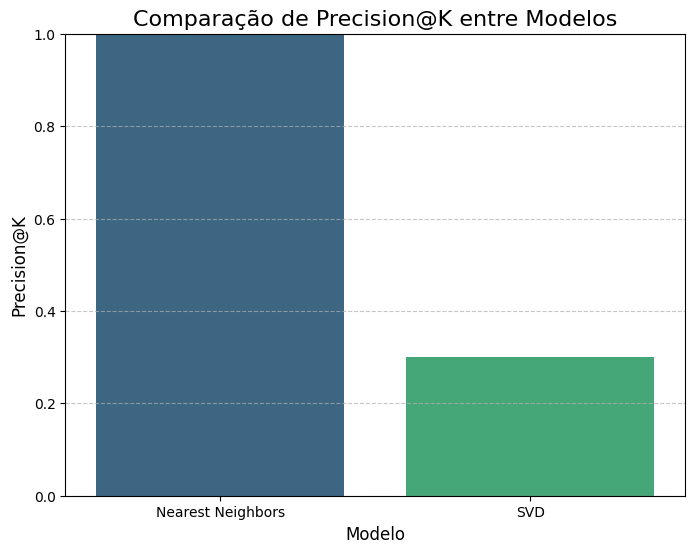

In [355]:
# Dados para o gráfico
model_names = ['Nearest Neighbors', 'SVD']
precision_scores = [nn_precision_k, svd_precision_k]

# Criar o gráfico de comparação
plt.figure(figsize=(8, 6))
sns.barplot(x=model_names, y=precision_scores, palette="viridis")
plt.title("Comparação de Precision@K entre Modelos", fontsize=16)
plt.ylabel("Precision@K", fontsize=12)
plt.xlabel("Modelo", fontsize=12)
plt.ylim(0, 1)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


No caso de ambiguidade temos um processo para detetar 10 filmes com o nome semelhante e permitir ao utilizador escolher aquele que se adequa ao que ele pretende

In [ ]:
# Novo exemplo de uso: usuário insere filmes por título
user_input = [
    'wall'
]

recommendations = movie_recomendation(user_input, movies, nn_model, reduced_matrix)
display(recommendations)


O título 'wall' é ambíguo. Selecione uma das opções abaixo (máximo 10 opções):


,title,year,genre
1,Pink Floyd: The Wall,1982,"Drama,Fantasy,Music"
2,The Wall,1983,Drama
3,Wall Street,1987,"Crime,Drama"
4,Swallowtail Butterfly,1996,"Crime,Drama"
5,Meet Wally Sparks,1997,Comedy
6,Wallace & Gromit: The Curse of the Were-Rabbit,2005,"Adventure,Animation,Comedy"
7,Firewall,2006,"Crime,Thriller"
8,WALL·E,2008,"Adventure,Animation,Family"
9,The Wolf of Wall Street,2013,"Biography,Comedy,Crime"
10,Wall Street: Money Never Sleeps,2010,Drama


In [346]:
# Exemplo de uso
user_input = ["interstellar"]

recommendations = movie_recomendation(user_input, movies, nn_model, reduced_matrix)
display(recommendations)


Recomendações baseadas no título 'Interstellar':


,title,year,genre,rating,votes
13514,Inception,2010,"Action,Adventure,Sci-Fi",8.8,"2,639,711"
10597,The Prestige,2006,"Drama,Mystery,Sci-Fi",8.5,"1,490,730"
10432,The Dark Knight,2008,"Action,Crime,Drama",9.0,"2,972,521"
14942,Chronicle,2012,"Adventure,Drama,Sci-Fi",7.0,"268,235"
13395,The Dark Knight Rises,2012,"Action,Drama,Thriller",8.4,"1,887,290"
10808,Man of Steel,2013,"Action,Adventure,Sci-Fi",7.1,"827,598"
9322,Batman Begins,2005,"Action,Drama",8.2,"1,625,041"
14294,Oppenheimer,2023,"Biography,Drama,History",8.3,"841,294"
19088,Dunkirk,2017,"Action,Drama,History",7.8,"762,940"
10659,Jumper,2008,"Action,Adventure,Sci-Fi",6.1,"329,087"


In [345]:
# Novo exemplo de uso: usuário insere filmes por título
user_input = [
    'Avatar: The Way of Water',
    'The Lord of the Rings: The Fellowship of the Ring',
    'Harry Potter and the Sorcerer\'s Stone',
    'Avengers: Age of Ultron',
    'Star Wars: Episode IV - A New Hope'
]


recommendations = movie_recomendation(user_input, movies, nn_model, reduced_matrix)
display(recommendations)



Recomendações baseadas no título 'Avatar: The Way of Water, The Lord of the Rings: The Fellowship of the Ring, Harry Potter and the Sorcerer's Stone, Avengers: Age of Ultron, Star Wars: Episode IV - A New Hope':


,title,year,genre,rating,votes
7460,The Lord of the Rings: The Return of the King,2003,"Adventure,Drama,Fantasy",9.0,"2,048,300"
7461,The Lord of the Rings: The Two Towers,2002,"Adventure,Drama,Fantasy",8.8,"1,846,775"
3500,Star Wars: Episode V - The Empire Strikes Back,1980,"Action,Adventure,Fantasy",8.7,"1,421,134"
5415,Terminator 2: Judgment Day,1991,"Action,Adventure,Sci-Fi",8.6,"1,214,807"
18522,Avengers: Endgame,2019,"Action,Adventure,Drama",8.4,"1,326,879"
18521,Avengers: Infinity War,2018,"Action,Adventure,Sci-Fi",8.4,"1,261,023"
3947,Star Wars: Episode VI - Return of the Jedi,1983,"Action,Adventure,Fantasy",8.3,"1,150,840"
10749,Avatar,2009,"Action,Adventure,Fantasy",7.9,"1,416,660"
12691,Harry Potter and the Deathly Hallows: Part 2,2011,"Adventure,Family,Fantasy",8.1,"982,133"
4130,The Terminator,1984,"Action,Adventure,Sci-Fi",8.1,"952,300"
